# Stroke Classification

In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import pickle
!pip install imbalanced-learn

## Data cleaning and prep

In [2]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# make a copy so we keep the original data untouched
stroke_copy = stroke_df.copy()

In [4]:
#with na's dropped we hardly lose data so we decided to just drop NA's
stroke_copy.dropna(inplace=True)

In [5]:
#The id column is irrelevant so just decided to drop it.
stroke_copy = stroke_copy.drop(columns=['id'])

In [6]:
stroke_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


### One Hot Encoding to prep data for modeling.

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

In [8]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [9]:
numerical_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [10]:
stroke_categorical = stroke_copy[categorical_columns]
stroke_numerical = stroke_copy[numerical_columns]

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
stroke_categorical = pd.DataFrame(data=ohe.fit_transform(stroke_categorical), 
                                           columns=ohe.get_feature_names_out(categorical_columns))

In [12]:
stroke_encoded = pd.concat([stroke_numerical.reset_index(drop=True), stroke_categorical.reset_index(drop=True)], axis=1)
stroke_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


### Data trainging

In [13]:
X = stroke_encoded.drop(columns = 'stroke')
y = stroke_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
X_train.isna().sum()/len(stroke_encoded)

age                               0.0
hypertension                      0.0
heart_disease                     0.0
avg_glucose_level                 0.0
bmi                               0.0
gender_Female                     0.0
gender_Male                       0.0
gender_Other                      0.0
ever_married_No                   0.0
ever_married_Yes                  0.0
work_type_Govt_job                0.0
work_type_Never_worked            0.0
work_type_Private                 0.0
work_type_Self-employed           0.0
work_type_children                0.0
Residence_type_Rural              0.0
Residence_type_Urban              0.0
smoking_status_Unknown            0.0
smoking_status_formerly smoked    0.0
smoking_status_never smoked       0.0
smoking_status_smokes             0.0
dtype: float64

In [54]:
y.value_counts()

stroke
0    4700
1     209
Name: count, dtype: int64

## Logistic Regression Model 

In [15]:
# Scale
# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

StandardScaler()

In [16]:
# Transform the training and testing data by using the X_scaler model
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [53]:
with open('scaler.pkl', 'wb') as n:
    pickle.dump(X_scaler, n)  

In [17]:
#Apply SMOTE to the training data:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Check the new class distribution:
print(pd.Series(y_resampled).value_counts())

stroke
0    3515
1    3515
Name: count, dtype: int64


In [18]:
# Create a `LogisticRegression` function and assign it 
# to a variable named `logistic_regression_model`.
logistic_regression_model = LogisticRegression()

# Fit the model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [19]:
# Score the model
print(f"Training Data Score: {logistic_regression_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logistic_regression_model.score(X_test_scaled, y_test)}")

Training Data Score: 0.9551752241238793
Testing Data Score: 0.9649837133550488


In [62]:
# Create a SMOTE `LogisticRegression` function and assign it 
# to a variable named `logistic_regression_model`.
logistic_regression_model_smote = LogisticRegression()

# Fit the model
logistic_regression_model_smote.fit(X_resampled, y_resampled)

LogisticRegression()

In [63]:
# Score the SMOTE LR model
print(f"SMOTE Training Data Score: {logistic_regression_model_smote.score(X_resampled, y_resampled)}")
print(f"SMOTE Testing Data Score: {logistic_regression_model_smote.score(X_test_scaled, y_test)}")

SMOTE Training Data Score: 0.7805120910384068
SMOTE Testing Data Score: 0.7345276872964169


In [64]:
# SMOTE Predict
y_pred_resampled = logistic_regression_model_smote.predict(X_test_scaled)

In [65]:
# SMOTE Confusion Matrix
cm = confusion_matrix(y_test, y_pred_resampled)
print(cm)

[[866 319]
 [  7  36]]


In [49]:
file = 'reg_model.sav'
with open(file, 'wb') as f:
    pickle.dump(logistic_regression_model_smote, f)

In [24]:
# Scaled Predict
y_pred = logistic_regression_model.predict(X_test_scaled)

In [25]:
# Scaled Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1185    0]
 [  43    0]]


### Random Forest

In [26]:
# Create a SMOTE `LogisticRegression` function and assign it 
# to a variable named `logistic_regression_model`.
random_forest_model_smote = RandomForestClassifier()

# Fit the model
random_forest_model_smote.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [27]:
# Evaluate the SMOTE Random Forest model
print(f'Training Score: {random_forest_model_smote.score(X_resampled, y_resampled)}')
print(f'Testing Score: {random_forest_model_smote.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.9275244299674267


In [28]:
# SMOTE Predict
y_pred_resampled = random_forest_model_smote.predict(X_test_scaled)

In [29]:
# SMOTE Confusion Matrix
cm = confusion_matrix(y_test, y_pred_resampled)
print(cm)

[[1133   52]
 [  37    6]]


# Gradient boost classifier

In [66]:
# Train the Gradient Boosting classifier
clf = GradientBoostingClassifier(random_state=1).fit(X_resampled, y_resampled)
# Evaluate the model
print(f'Training Score: {clf.score(X_resampled, y_resampled)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.9095305832147937
Testing Score: 0.8615635179153095


In [67]:
# SMOTE Predict Gradient Boost
y_pred_clf = clf.predict(X_test_scaled)

In [68]:
# SMOTE Confusion Matrix Gradient Boost
cm = confusion_matrix(y_test, y_pred_clf)
print(cm)

[[1044  141]
 [  29   14]]


In [52]:
filename = 'gbc.sav'
with open(file,'wb') as r:
    pickle.dump(clf, r)

In [69]:
feature_importances = clf.feature_importances_

In [70]:
importances_sorted = sorted(zip(feature_importances, X.columns), reverse=True)
importances_sorted[:10]

[(0.659841921826719, 'age'),
 (0.044697455371465494, 'smoking_status_never smoked'),
 (0.04254036148634224, 'work_type_Private'),
 (0.037750664341642565, 'avg_glucose_level'),
 (0.02960720645840769, 'Residence_type_Rural'),
 (0.028192822830259093, 'gender_Female'),
 (0.025503506819693718, 'Residence_type_Urban'),
 (0.023840600079353024, 'bmi'),
 (0.019856544684203142, 'hypertension'),
 (0.01575273032199329, 'ever_married_Yes')]

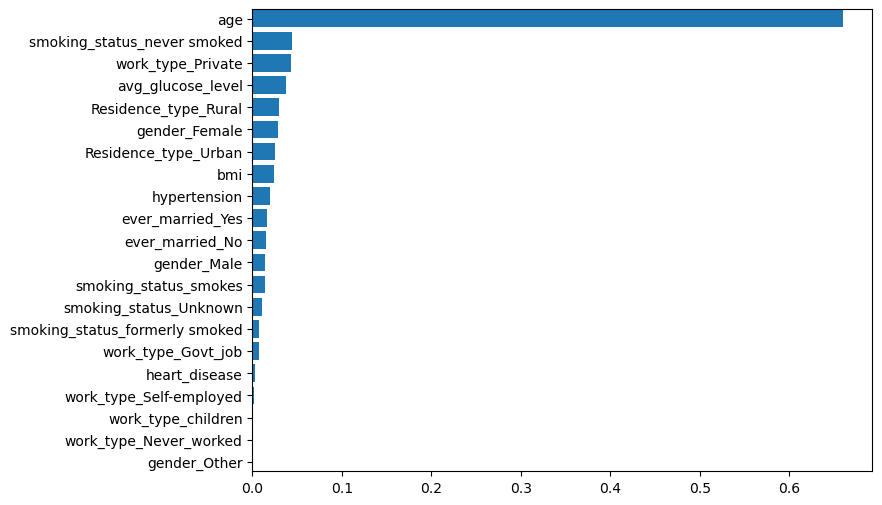

In [71]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [33]:
# GridSearch

In [34]:
#Set up the parameter grid:

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5]
}

In [35]:
# Create the GridSearchCV object

grid_clf = GridSearchCV(clf, param_grid, verbose=3, cv=5)

In [36]:
# Fit the model

grid_clf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.792 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.803 total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.781 total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.797 total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.804 total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.796 total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.799 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.783 total time=   0.5s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.794 total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.814 to

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [37]:
# Check the best parameters

print("Best parameters found: ", grid_clf.best_params_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


In [38]:
#Evaluate the model

best_model = grid_clf.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test score: ", test_score)

Test score:  0.9356677524429967


In [39]:
y_pred_final = best_model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_final))

[[1146   39]
 [  40    3]]


### SVC Model

In [40]:
# Create a `SVC` function and assign it to a variable named `model`.
model = SVC(kernel='linear')
model.fit(X_train_scaled, y_train)

# Score the model
print('Train Accuracy: %.3f' % model.score(X_train_scaled, y_train))
print('Test Accuracy: %.3f' % model.score(X_test_scaled, y_test))

Train Accuracy: 0.955
Test Accuracy: 0.965


### Decision Tree Model

In [41]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=5)
model = model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.9625407166123778


In [42]:
# import pydotplus
# from IPython.display import Image

# # Create DOT data
# dot_data = tree.export_graphviz(
#     model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
# )
# # Draw graph
# graph = pydotplus.graph_from_dot_data(dot_data)
# # Show graph
# Image(graph.create_png())